In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import time

from math import sqrt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt

In [45]:
RANDOM_STATE = 6578439


def root_mean_square_percentage(labels, predictions):
    """ As defined by competition """
    if len(labels) != len(predictions):
        raise Exception("Labels and predictions must be of same length")
    # Filter pairs where label == 0
    labels, predictions = tuple(
        zip(*filter(lambda x: x[0] != 0, zip(labels, predictions)))
    )
    labels = numpy.array(labels, dtype=float)
    predictions = numpy.array(predictions, dtype=float)
    return sqrt(numpy.power((labels - predictions) / labels, 2.0).sum() / len(labels))


if __name__ == '__main__':
    print "Loading annotated dataset..."
    annotated_df = pandas.read_csv(
        'data/train.csv',
        dtype={
            'StateHoliday': object,
            'Sales': float,
            'Customers': float,
        },
        parse_dates=['Date']
    )
    
    print "Loading stores dataset..."
    stores_df = pandas.read_csv(
        'data/store.csv',
        dtype = {
            "Store": int,
            "DayOfWeek": int,       # {1, 2, 3, 4, 5, 6, 7}
            "Date": object,         # e.g. "2015-07-31"
            "Sales": int,
            "Customers": int,
            "Open": bool,
            "Promo": bool,
            "StateHoliday": str,    # {'0', 'a', 'b', 'c'}
            "SchoolHoliday": bool,
        }
    )
    
    print "Done loading datasets!"




Loading annotated dataset...
Loading stores dataset...
Done loading datasets!


In [46]:
stores_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910,4,2015,0,NaN,NaN,NaN


In [49]:
full_df = pandas.merge(annotated_df, stores_df)

In [52]:
annotated_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [51]:
full_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN


In [55]:
print "Preparing annotated dataset for sklearn usage..."
annotated_df['StateHoliday'] = LabelEncoder().fit_transform(annotated_df['StateHoliday'])

print "Enriching annotated dataset with extra features..."
annotated_df['DayOfMonth'] = annotated_df['Date'].apply(lambda dt: dt.day)
annotated_df['Month'] = annotated_df['Date'].apply(lambda dt: dt.month)
annotated_df['Year'] = annotated_df['Date'].apply(lambda dt: dt.year)
annotated_df['UnixTimestamp'] = annotated_df['Date'].apply(lambda dt: time.mktime(dt.timetuple()))
annotated_df.drop('Date', axis=1, inplace=True)

Preparing annotated dataset for sklearn usage...
Enriching annotated dataset with extra features...


In [56]:
print "Splitting train and test sets..."
train_df, test_df = train_test_split(
    annotated_df,
    test_size=0.10,
    random_state=RANDOM_STATE
)

print "Training random forest..."
random_forest = RandomForestRegressor(
    n_jobs=-1,  # Auto selects number of cores
    random_state=RANDOM_STATE,
    max_features="log2",
    n_estimators=10,
).fit(
    X=train_df[train_df.columns.difference(['Sales'])],
    y=train_df['Sales'],
)
print "Feature importances:"
pairs = zip(train_df.columns.difference(['Sales']), random_forest.feature_importances_)
pairs.sort(key=lambda x: -x[1])
for column, importance in pairs:
    print " ", column, importance

print "Testing random forest..."
predictions = random_forest.predict(
    X=test_df[test_df.columns.difference(['Sales'])],
)
print "Root mean square percentage:"
print " ", root_mean_square_percentage(test_df['Sales'], predictions)

Splitting train and test sets...
Training random forest...


ValueError: could not convert string to float: d

array([ 7815.3,  9163.5,  3195.7, ...,     0. ,     0. ,     0. ])

In [ ]:
predictions_df = pandas.DataFrame({'Sales':predictions})

In [ ]:
mask = predictions_df.Sales != 0
predictions_df[mask].Sales.hist(bins=100)
print predictions_df.median()
print predictions_df.mean()
print predictions_df.std()

Store                   558
DayOfWeek                 4
Sales                  5744
Customers               609
Open                      1
Promo                     0
StateHoliday              0
SchoolHoliday             0
DayOfMonth               16
Month                     6
Year                   2014
UnixTimestamp    1396389600
dtype: float64
Store            5.582410e+02
DayOfWeek        3.998639e+00
Sales            5.773654e+03
Customers        6.331056e+02
Open             8.300852e-01
Promo            3.813715e-01
StateHoliday     4.524581e-02
SchoolHoliday    1.786992e-01
DayOfMonth       1.569863e+01
Month            5.847853e+00
Year             2.013832e+03
UnixTimestamp    1.397163e+09
dtype: float64
Store                 321.912126
DayOfWeek               1.997523
Sales                3849.586467
Customers             464.327282
Open                    0.375558
Promo                   0.485724
StateHoliday            0.284062
SchoolHoliday           0.383100
DayOfMonth

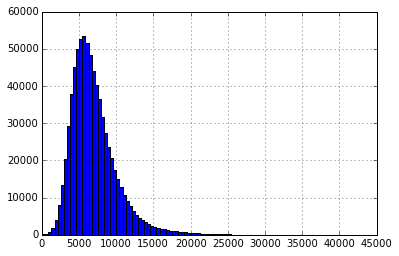

In [43]:
mask = train_df.Sales != 0
train_df[mask].Sales.hist(bins=100)
print train_df.median()
print train_df.mean()
print train_df.std()